In [ ]:
import os, kagglehub, cv2, pickle, random, shutil, gc
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Conv2D, MaxPooling2D, ZeroPadding2D, Lambda
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, AdamW
from tensorflow.keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
def get_optimizer(optimizer_name, learning_rate):
    if optimizer_name.lower() == 'adam':
        return Adam(learning_rate=learning_rate)
    elif optimizer_name.lower() == 'sgd':
        return SGD(learning_rate=learning_rate)
    elif optimizer_name.lower() == 'rmsprop':
        return RMSprop(learning_rate=learning_rate)
    elif optimizer_name.lower() == 'adamw':
        return AdamW(learning_rate=learning_rate)
    else:
        raise ValueError(f"Optimizer '{optimizer_name}' not supported.")

In [ ]:
path = kagglehub.dataset_download("orvile/brain-cancer-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-cancer-mri-dataset


In [ ]:
original_dataset_dir = '/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer'

base_dir = 'brain-cancer-mri-dataset_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_split = 0.7
val_split = 0.15
test_split = 0.15

for category in ['train', 'val', 'test']:
    for class_name in os.listdir(original_dataset_dir):
        os.makedirs(os.path.join(base_dir, category, class_name), exist_ok=True)

for class_name in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)

    total_images = len(images)
    train_count = int(total_images * train_split)
    val_count = int(total_images * val_split)

    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    for image in tqdm(train_images, desc=f'Train - {class_name}'):
        shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))

    for image in tqdm(val_images, desc=f'Val - {class_name}'):
        shutil.copy(os.path.join(class_path, image), os.path.join(val_dir, class_name, image))

    for image in tqdm(test_images, desc=f'Test - {class_name}'):
        shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))

Test - brain_menin: 100%|██████████| 302/302 [00:01<00:00, 158.56it/s]


In [ ]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

datagen_val_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = datagen_val_test.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen_val_test.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4237 images belonging to 3 classes.
Found 907 images belonging to 3 classes.
Found 912 images belonging to 3 classes.


In [ ]:
input_shape = (224, 224, 3)
optimizer = 'adam'
model2 = Sequential([

        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),

        Conv2D(64, (5, 5), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(128, (5, 5), activation='relu'),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(3, activation='softmax')
    ])

model2.compile(optimizer=get_optimizer(optimizer, 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 107, 107, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 49, 49, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     9,437,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,694,787 (36.98 MB)

 Trainable params: 9,694,787 (36.98 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)


history2 = model2.fit(train_generator, epochs=50,
          validation_data=val_generator,
          callbacks=[early_stop, model_checkpoint])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.5223 - loss: 0.9778

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


133/133 ━━━━━━━━━━━━━━━━━━━━ 59s 394ms/step - accuracy: 0.5229 - loss: 0.9768 - val_accuracy: 0.7200 - val_loss: 0.6848
Epoch 2/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 48s 363ms/step - accuracy: 0.6992 - loss: 0.6866 - val_accuracy: 0.7916 - val_loss: 0.5242
Epoch 3/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 48s 364ms/step - accuracy: 0.7473 - loss: 0.5964 - val_accuracy: 0.8026 - val_loss: 0.4638
Epoch 4/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 48s 363ms/step - accuracy: 0.7647 - loss: 0.5714 - val_accuracy: 0.8291 - val_loss: 0.4280
Epoch 5/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 48s 361ms/step - accuracy: 0.7865 - loss: 0.5089 - val_accuracy: 0.8203 - val_loss: 0.4457
Epoch 6/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 48s 363ms/step - accuracy: 0.7967 - loss: 0.4965 - val_accuracy: 0.8655 - val_loss: 0.3643
Epoch 7/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 48s 358ms/step - accuracy: 0.8017 - loss: 0.4945 - val_accuracy: 0.8280 - val_loss: 0.4173
Epoch 8/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 48s 362ms/step - accuracy: 0.7923 - loss: 0.5002 - val

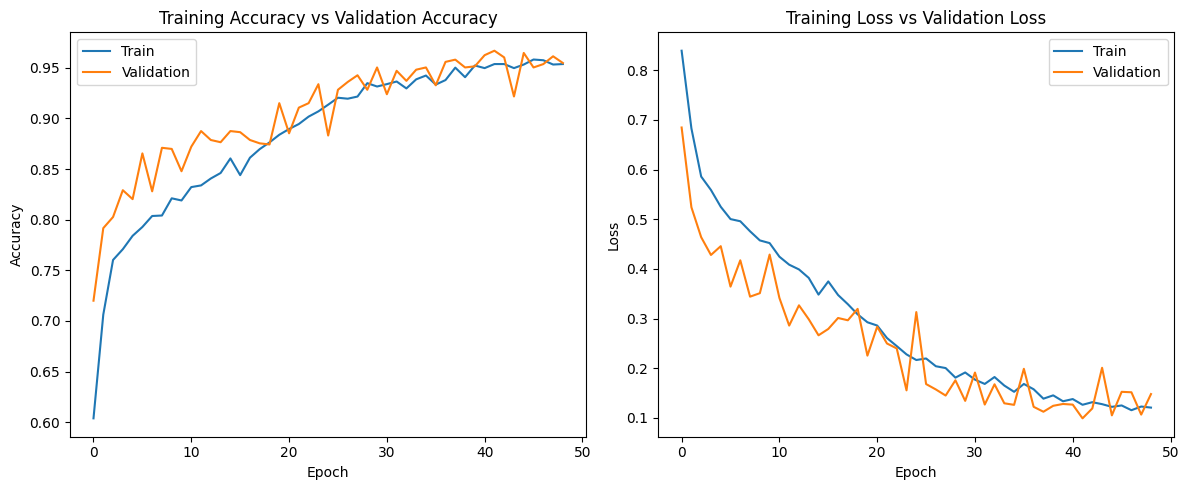

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train')
plt.plot(history2.history['val_loss'], label='Validation')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
train_loss, train_acc = model2.evaluate(train_generator, verbose=0)
print(f"✅ Train Accuracy: {train_acc:.4f}")

val_loss, val_acc = model2.evaluate(val_generator, verbose=0)
print(f"✅ Validation Accuracy: {val_acc:.4f}")

test_loss, test_acc = model2.evaluate(test_generator, verbose=0)
print(f"✅ Test Accuracy: {test_acc:.4f}")

✅ Train Accuracy: 0.9559
✅ Validation Accuracy: 0.9669


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


✅ Test Accuracy: 0.9693


In [ ]:
test_predictions = model2.predict(test_generator)
test_predictions_classes = np.argmax(test_predictions, axis=1)

test_true_labels = test_generator.classes

class_names = list(test_generator.class_indices.keys())

report = classification_report(test_true_labels, test_predictions_classes, target_names=class_names)
print("Classification Report:\n", report)

f1 = f1_score(test_true_labels, test_predictions_classes, average='weighted')
recall = recall_score(test_true_labels, test_predictions_classes, average='weighted')

print(f"\nWeighted F1-score: {f1:.4f}")
print(f"Weighted Recall: {recall:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step
Classification Report:
               precision    recall  f1-score   support

brain_glioma       0.98      0.97      0.98       302
 brain_menin       0.95      0.96      0.96       302
 brain_tumor       0.97      0.97      0.97       308

    accuracy                           0.97       912
   macro avg       0.97      0.97      0.97       912
weighted avg       0.97      0.97      0.97       912


Weighted F1-score: 0.9693
Weighted Recall: 0.9693


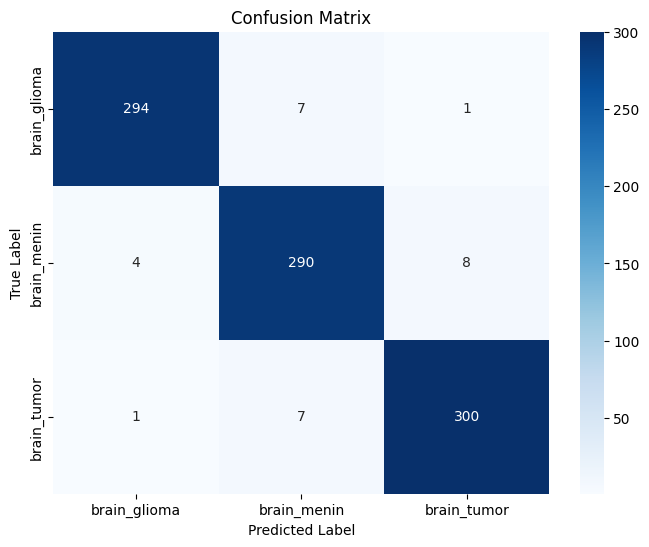

In [ ]:
cm = confusion_matrix(test_true_labels, test_predictions_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()